# 1. Nhập dữ liệu

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mordred import Calculator, descriptors

In [3]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("../data_for_modeling/HDAC3_test.csv")
train_dataset = pd.read_csv("../data_for_modeling/HDAC3_train.csv")

# 2. Xây dựng mô hình với Modred descriptors

## 2.1. Tính toán mordred descriptors

__Mã hóa cấu trúc phân tử bằng Modred descriptors__

In [4]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    # pandas df
    df = calc.pandas(mols)
    return df

In [4]:
calc = Calculator(descriptors, ignore_3D=True)
mols = Chem.MolFromSmiles("Cc1csc(C(=O)NCCCCCC(=O)Nc2ccccc2N)n1")
b_des = calc.pandas([mols])
b_des = pd.DataFrame(b_des)

100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


In [9]:
#Tìm các dữ liệu (2'18s) 
train_modred_descriptors = All_Mordred_descriptors(train_dataset['SMILES'])
test_mordred_descriptors = All_Mordred_descriptors(test_dataset['SMILES'])

100%|██████████| 198/198 [00:13<00:00, 14.74it/s]


In [10]:
train_np = np.array(train_modred_descriptors)
test_np = np.array(test_mordred_descriptors)
for (row, col), value in np.ndenumerate(train_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        train_np[row, col] = 0
        
for (row, col), value in np.ndenumerate(test_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        test_np[row, col] = 0

train_modred_descriptors = pd.DataFrame(train_np, columns=train_modred_descriptors.columns)
test_mordred_descriptors = pd.DataFrame(test_np, columns=test_mordred_descriptors.columns)

In [12]:
test_mordred_descriptors.to_csv("../output/test_modred_des.csv", index=False)
train_modred_descriptors.to_csv("../output/train_modred_des.csv", index=False)

__Làm sạch dữ liệu__

- Do thuật toán mã hóa Modred không thể tìm được mọi features của SMILES nên sẽ có một số chỗ không phải là số thực mà là một object báo lỗi, ta sẽ loại bỏ tất cả object báo lỗi này.
- Các dữ liệu sau khi xử lý có giá trị khác numpy.float64 và numpy.int64 thì cho bằng 0.
- Toàn bộ dữ liệu ta xử lý đều là dữ liệu số, vì vậy ta sẽ đặt những object này với giá trị bằng 0.

In [13]:
train_np = np.array(train_modred_descriptors)
test_np = np.array(test_mordred_descriptors)

In [14]:
for (row, col), value in np.ndenumerate(train_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        train_np[row, col] = 0
        
for (row, col), value in np.ndenumerate(test_np):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        test_np[row, col] = 0

## 2.2 Tiền xử lý dữ liệu

## Feature selection

In [24]:
test_mordred_descriptors = pd.DataFrame(test_np, columns=test_mordred_descriptors.columns)
train_modred_descriptors = pd.DataFrame(train_np, columns=train_modred_descriptors.columns)

In [25]:
all_mordred_descriptors = pd.concat([test_mordred_descriptors, train_modred_descriptors], ignore_index=False)
ic50_train = np.array(train_dataset['IC50_mean'])
ic50_test = np.array(test_dataset['IC50_mean'])

for i, value in np.ndenumerate(ic50_train):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        ic50_train[i] = 0
        
for i, value in np.ndenumerate(ic50_test):
    if not (value.__class__ in [int, float, np.float64, np.float32, np.int64, np.int32]):
        ic50_test[i] = 0
        
ic50_all = np.append(ic50_train, ic50_test)
all_mordred_descriptors['IC50'] = ic50_all

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
all_modred_np = sc.fit_transform(all_mordred_descriptors)
all_modred_data = pd.DataFrame(all_modred_np, columns=all_mordred_descriptors.columns)
corr_matrix = all_modred_data.corr(method="pearson")

<Axes: >

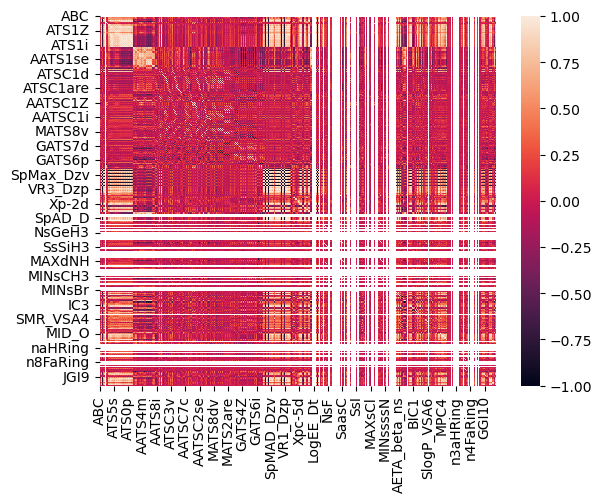

In [27]:
sns.heatmap(corr_matrix)

In [28]:
corr_matrix = corr_matrix.dropna(subset=['IC50'])
ic50_corrs_abs = corr_matrix['IC50'].abs()
features = corr_matrix.loc[ic50_corrs_abs > 0.05, :].index.tolist()

In [30]:
df_selected = corr_matrix.loc[features, features]
sorted_df = df_selected.sort_values(by='IC50', ascending=False)
above_095 = sorted_df > 0.95
rows_count = len(df_selected)
count = 0
shapes = [] 
features = []
for idx, row in sorted_df.iterrows():
    if count < rows_count:
        # create a list of columns to drop
        cols_rows_to_drop = []
        # iterate over the columns
        for col in sorted_df.columns:
            # check if the value is True
            if above_095.loc[idx, col]:
                cols_rows_to_drop.append(col)
        # drop the columns
        sorted_df = sorted_df.drop(cols_rows_to_drop, axis=1).drop(cols_rows_to_drop, axis=0)
        shapes.append(sorted_df.shape)
        features.append(sorted_df.index.to_list())  
        # check if there are any rows left
        if len(sorted_df) == 0:
            break
        count += 1
    else:
        break

In [31]:
sorted_df.shape

(0, 0)

In [32]:
# create a DataFrame with the shapes and features
df_shapes = pd.DataFrame({'Shapes': shapes, 'Features': features})
# write the DataFrame to an Excel file
filename = '../output/shapes_and_features.xlsx'
df_shapes.to_excel(filename, index=True)

__Ứng dụng Features selection với hàm selectKBest để chọn ra 27 features có ảnh hưởng nhất__
- 27 là số features mà tác giả tìm ra sau khi lọc

In [56]:
y_Train_des = np.array(train_dataset['Type'])
y_Test_des = np.array(test_dataset['Type'])

__Sử dụng Variance Threshold nhằm loại bỏ các features có low variance__

__Tập dữ liệu đầu vào X của tác giả__

In [150]:
authors_features_mine = ['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s', 'GATS1are', 'AATSC3d'
                    , 'PEOE_VSA2', 'AATS4v', 'AATS4Z', 'GATS3d', 'MATS3m', 'AXp-5dv', 'EState_VSA4',
                    'ETA_eta_L', 'ATSC5m', 'RotRatio', 'SsNH2', 'ETA_epsilon_5', 'SlogP_VSA2',
                    'MID_N', 'EState_VSA5', 'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d']

authors_features = ['Xc-4dv', 'Kier3', 'CIC4', 
 'CIC5', 'NaaS', 'VR3_A', 
 'GATS4c', 'NdO', 'AATS1d', 
 'n6aRing', 'fMF', 'AATS2v', 
 'n6Ring', 'ATSC8p', 'SlogP_VSA6', 
 'AATSC4c', 'ETA_dEpsilon_B', 'MATS4c', 
 'ATSC4c', 'MATS1c', 'MATS8m', 'MATS8Z', 
 'ATSC1c', 'AATSC8m', 'AATSC8Z', 'ATSC8m', 'ATSC8Z']

X_Train_author = pd.DataFrame()
for feature in authors_features:
    X_Train_author[feature] = train_modred_descriptors[feature]
X_Train_author = X_Train_author.astype(float)
X_Train_author.head()

,Xc-4dv,Kier3,CIC4,CIC5,NaaS,VR3_A,GATS4c,NdO,AATS1d,n6aRing,...,MATS4c,ATSC4c,MATS1c,MATS8m,MATS8Z,ATSC1c,AATSC8m,AATSC8Z,ATSC8m,ATSC8Z
0,0.0,7.424397,0.407715,0.364237,1.0,7.066593,1.339615,2.0,3.510638,1.0,...,-0.187507,-0.386933,-0.651961,-0.052446,-0.053599,-0.619923,-2.497018,-0.556962,-197.264452,-44.000000
1,0.0,7.183673,0.311111,0.266667,0.0,6.301954,1.358274,2.0,3.500000,1.0,...,-0.197992,-0.437652,-0.649818,-0.026105,-0.026602,-0.660740,-0.913744,-0.195556,-69.444579,-14.862222
2,0.0,8.500000,0.067797,0.067797,0.0,8.718481,1.245672,2.0,4.064516,3.0,...,-0.168593,-0.508199,-0.474211,0.089087,0.087335,-0.628547,3.160039,0.647702,432.925342,88.735134
3,0.0,9.140076,0.313725,0.274510,0.0,8.142871,1.123971,2.0,3.673077,2.0,...,0.020109,0.058829,-0.656468,-0.064767,-0.064530,-0.853560,-2.518196,-0.521199,-236.710379,-48.992695
4,0.0,6.790123,0.272727,0.272727,0.0,8.605780,1.198892,2.0,3.577778,2.0,...,-0.116942,-0.188970,-0.612933,-0.098078,-0.098309,-0.454802,-4.693553,-1.027778,-337.935851,-74.000000


In [159]:
mine_ic50 = ['Xc-4dv', 'MATS4s', 'GATS1dv', 
            'SdssC', 'BCUTd-1h', 'GATS1s', 
            'GATS1are', 'AATSC3d', 'PEOE_VSA2', 
            'AATS4v', 'AATS4Z', 'GATS3d', 'MATS3m', 
            'AXp-5dv', 'EState_VSA4','ETA_eta_L', 
            'ATSC5m', 'RotRatio', 'SsNH2', 'ETA_epsilon_5',
            'SlogP_VSA2', 'MID_N', 'EState_VSA5', 
            'Xc-5dv', 'JGI5', 'GATS5pe', 'AATSC4d', 'IC50']

af_ic50 = ['Xc-4dv', 'Kier3', 'CIC4', 
 'CIC5', 'NaaS', 'VR3_A', 
 'GATS4c', 'NdO', 'AATS1d', 
 'n6aRing', 'fMF', 'AATS2v', 
 'n6Ring', 'ATSC8p', 'SlogP_VSA6', 
 'AATSC4c', 'ETA_dEpsilon_B', 'MATS4c', 
 'ATSC4c', 'MATS1c', 'MATS8m', 'MATS8Z', 
 'ATSC1c', 'AATSC8m', 'AATSC8Z', 'ATSC8m', 'ATSC8Z', 'IC50']

author_corr_matrix = corr_matrix.loc[mine_ic50, mine_ic50]
mine_corr_matrix = corr_matrix.loc[af_ic50, af_ic50]

sorted_df = df_selected.sort_values(by='IC50', ascending=False)

mine_corr_matrix = pd.DataFrame(mine_corr_matrix)
author_corr_matrix = pd.DataFrame(author_corr_matrix)
mine_corr_matrix.to_csv("../output/mine_corr_matrix.csv")
author_corr_matrix.to_csv("../output/author_corr_matrix.csv")

In [126]:
X_Test_author_des = pd.DataFrame()
for feature in X_Train_author.columns:
    X_Test_author_des[feature] = test_mordred_descriptors[feature]
X_Test_author_des = X_Test_author_des.astype(float)
X_Test_author_des.head()

,Xc-4dv,Kier3,CIC4,CIC5,NaaS,VR3_A,GATS4c,NdO,AATS1d,n6aRing,...,MATS4c,ATSC4c,MATS1c,MATS8m,MATS8Z,ATSC1c,AATSC8m,AATSC8Z,ATSC8m,ATSC8Z
0,0.013499,9.436385,0.461291,0.357843,0.0,10.155391,0.861084,2.0,3.983333,2.0,...,-0.008869,-0.022575,-0.531520,-0.031016,-0.032588,-0.583998,-1.217292,-0.264966,-133.902163,-29.146254
1,0.000000,9.436385,0.539683,0.349206,0.0,10.189339,0.890236,2.0,3.738462,2.0,...,-0.055535,-0.166357,-0.473707,-0.039006,-0.039550,-0.595067,-1.413578,-0.302429,-161.147920,-34.476946
2,0.000000,8.698225,0.400000,0.290909,0.0,9.767234,0.973757,2.0,3.824561,2.0,...,-0.040841,-0.075935,-0.474837,0.016360,0.015343,-0.396246,4.723329,0.768854,477.056238,77.654215
3,0.000000,7.258979,0.465414,0.354302,0.0,5.996262,0.951042,2.0,3.250000,1.0,...,-0.015874,-0.024029,-0.544640,-0.128356,-0.125212,-0.371015,-4.684152,-0.964211,-220.155165,-45.317901
4,0.000000,7.372800,0.480895,0.378330,0.0,6.218628,0.972995,2.0,3.230769,1.0,...,-0.023294,-0.035199,-0.544191,-0.026115,-0.022532,-0.372902,-0.943376,-0.171573,-49.998911,-9.093360


In [127]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_np = sc.fit_transform(X_Train_author)
X_test_np = sc.transform(X_Test_author_des)
X_Train_author = pd.DataFrame(X_train_np, columns = X_Train_author.columns)
X_Test_author_des = pd.DataFrame(X_test_np, columns = X_Train_author.columns)

<Axes: >

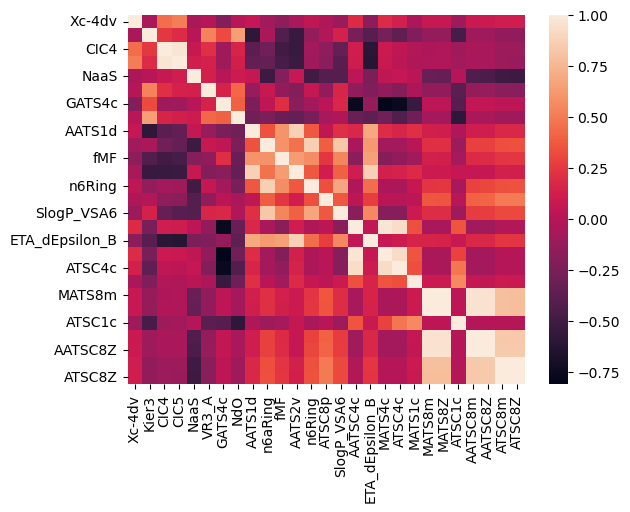

In [128]:
sns.heatmap(X_Train_author.corr())

In [129]:
X_Train_author.shape

(790, 27)

In [130]:
y_Train_des.shape

(790,)

In [131]:
X_Train_author.columns

Index(['Xc-4dv', 'Kier3', 'CIC4', 'CIC5', 'NaaS', 'VR3_A', 'GATS4c', 'NdO',
       'AATS1d', 'n6aRing', 'fMF', 'AATS2v', 'n6Ring', 'ATSC8p', 'SlogP_VSA6',
       'AATSC4c', 'ETA_dEpsilon_B', 'MATS4c', 'ATSC4c', 'MATS1c', 'MATS8m',
       'MATS8Z', 'ATSC1c', 'AATSC8m', 'AATSC8Z', 'ATSC8m', 'ATSC8Z'],
      dtype='object')

## 2.3. Xây dựng mô hình

- Có 5 mô hình cần được xây dựng đó là Random Forest, K-nearest neighbors, SVM, XGBoost và Deep Neural Network. Nhưng vì chưa học đến phần Deep Learning, nên em tạm thời bỏ qua DNN.
- Các đặt tên của các mô hình sau sẽ là <tên mô hình>_<cách mã hóa>
- VD: rf_des, XGBoost_morgan2, ...

#### Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier
rf_des_author = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_des_author.fit(X_Train_author, y_Train_des.reshape(len(y_Train_des)))

RandomForestClassifier(criterion='entropy', random_state=0)

#### K-nearest neighbors

In [133]:
from sklearn.neighbors import KNeighborsClassifier
knn_des_author = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_des_author.fit(X_Train_author, y_Train_des.reshape(len(y_Train_des)))

KNeighborsClassifier()

#### Support Vector Machine

In [134]:
from sklearn.svm import SVC
svm_des_author = SVC(kernel='rbf', random_state=0)
svm_des_author.fit(X_Train_author, y_Train_des)

SVC(random_state=0)

#### XGBoost

In [135]:
from xgboost import XGBClassifier
bst_des_author = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_des_author.fit(X_Train_author, y_Train_des)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# 3. Đánh giá mô hình

### 10-fold-cross validation

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [137]:
X_Total = np.concatenate((X_Train_author, X_Test_author_des), axis=0)
y_Total = np.concatenate((y_Train_des, y_Test_des), axis=0)

In [138]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(knn_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.833))

scores = cross_val_score(svm_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.847))

scores = cross_val_score(rf_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.857))

scores = cross_val_score(bst_des_author, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.822))

Độ chính xác của 10-fold cross validation: 0.800 (0.023)
So sánh với độ chính xác của bài báo là: 0.833
Độ chính xác của 10-fold cross validation: 0.784 (0.045)
So sánh với độ chính xác của bài báo là: 0.847
Độ chính xác của 10-fold cross validation: 0.804 (0.037)
So sánh với độ chính xác của bài báo là: 0.857
Độ chính xác của 10-fold cross validation: 0.816 (0.032)
So sánh với độ chính xác của bài báo là: 0.822


### Accuracy, Sensitivity, Specificity

In [139]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [140]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [141]:
def me_result(cm, ac1, se1, sp1, mcc1):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['Shin Liu et at', ac1, se1, sp1, mcc1], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

KNN

In [142]:
#KNN
y_knn_pred = knn_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_knn_pred)
ac1, se1, sp1, mcc1 = 0.859, 0.950, 0.644, 0.648
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 40  19]
 [ 12 127]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.859    │ 0.95     │ 0.644    │ 0.648    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.843434 │ 0.769231 │ 0.869863 │ 0.614907 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


SVM

In [143]:
#SVM
y_svm_pred = svm_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_svm_pred)
ac1, se1, sp1, mcc1 = 0.859 ,0.950 ,0.644 ,0.648
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 34  25]
 [ 14 125]]
Comparision:
╒════════════════╤═════════╤══════════╤══════════╤══════════╕
│                │      AC │       SE │       SP │      MCC │
╞════════════════╪═════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.859   │ 0.95     │ 0.644    │ 0.648    │
├────────────────┼─────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.80303 │ 0.708333 │ 0.833333 │ 0.507534 │
╘════════════════╧═════════╧══════════╧══════════╧══════════╛


RF

In [144]:
#SVM
y_rf_pred = rf_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_rf_pred)
ac1, se1, sp1, mcc1 = 0.798 ,0.827 ,0.729 ,0.538
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 40  19]
 [ 14 125]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.798    │ 0.827    │ 0.729    │ 0.538    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.833333 │ 0.740741 │ 0.868056 │ 0.592812 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


XGboost

In [145]:
y_bst_pred = bst_des_author.predict(X_Test_author_des)
cm = confusion_matrix(y_Test_des, y_bst_pred)
ac1, se1, sp1, mcc1 = 0.773 ,0.770 ,0.780 ,0.514
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 41  18]
 [ 14 125]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.773    │ 0.77     │ 0.78     │ 0.514    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.838384 │ 0.745455 │ 0.874126 │ 0.606755 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


### AUC

In [146]:
from sklearn.metrics import roc_auc_score
rf_auc_score = roc_auc_score(y_Test_des, y_rf_pred)
svm_auc_score = roc_auc_score(y_Test_des, y_svm_pred)
bst_auc_score = roc_auc_score(y_Test_des, y_bst_pred)
knn_auc_score = roc_auc_score(y_Test_des, y_knn_pred)
print(rf_auc_score, svm_auc_score, bst_auc_score, knn_auc_score)

0.7886233386172418 0.7377758809901231 0.7970979148884282 0.7958175832215583


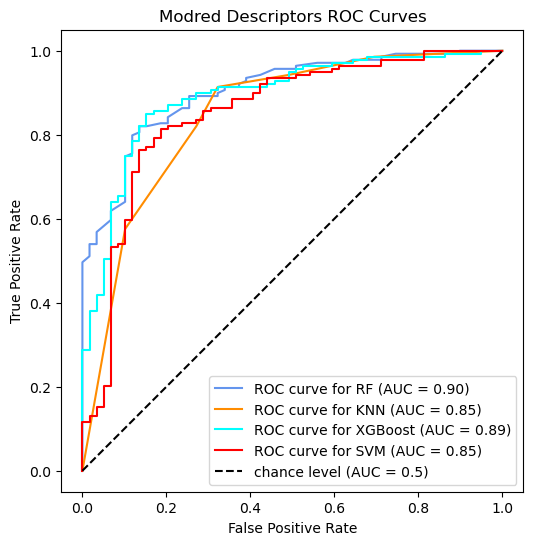

In [147]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_des_author, 
    X=X_Test_author_des, 
    y=y_Test_des,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Modred Descriptors ROC Curves")
plt.legend()
plt.show()